# Gaussian Processes with Autogradients

So Gaussian processes are a very popular machine learning algorithm for regression. They have useful properties due to the having flexible kernels as well as access to the derivative. However, they can be a bit difficult to program because there is an optimization step. In either case, the autogradient function should be useful in many aspects and I will attempt to use that functionality for the following parts of the GP Algorithm:
* Predictive Mean
* Negative Log Maximum Likelihood
* Predictive Variance

My code will be a rough representation of a few repos:

* Sklearn - [GaussianProcessRegressor](https://github.com/scikit-learn/scikit-learn/blob/f0ab589f/sklearn/gaussian_process/gpr.py)
* AMOGAPE - [AMOGAPE](https://github.com/dhsvendsen/AMOGAPE/blob/master/mintGP.py)
* Autograd - [gaussian process](https://github.com/geostk/autograd/blob/master/examples/gaussian_process.py)

I will have a class implementation based on the scikit-learn framework.

In [1]:
import numpy as np

In [87]:
import autograd
import autograd.numpy as np
from autograd import value_and_grad, elementwise_grad as egrad 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.gaussian_process.kernels import (_check_length_scale)
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_X_y, check_array
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

import sys
sys.path.insert(0,'/Users/eman/Documents/code_projects/kernellib/')
sys.path.insert(0,'/home/emmanuel/Drives/erc/code/kernellib')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

X training data: (20, 1)
X testing data: (1000, 1)


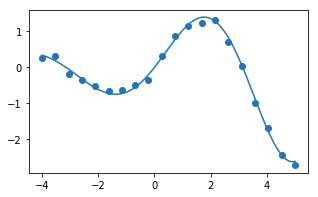

In [88]:
# get some toy data
d_dimensions = 1
n_samples = 20
noise_std = 0.1
seed = 123
rs = np.random.RandomState(seed)

n_train = 20
n_test = 1000
xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)
print('X training data:', xtrain.shape)
print('X testing data:', xtest.shape)


# Labels
f = lambda x: np.sin(x) * np.exp(0.2 * x)
ytrain = f(xtrain) + noise_std * np.random.randn(n_train, 1)
ytest = f(xtest)
# Plot the function
fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(xtrain, ytrain)
ax.plot(xtest, ytest)

plt.show()


## Kernel Function (RBF)

In [89]:
from sklearn.gaussian_process.kernels import (ConstantKernel as C, 
                                              RBF, WhiteKernel)

In [90]:
def rbf_covariance(X, y=None, signal_variance=1.0, length_scale=1.0):
    if y is None:
        y = X
    D = np.expand_dims(X / length_scale, 1) - np.expand_dims(y / length_scale, 0)
    return signal_variance * np.exp(-0.5 * np.sum(D**2, axis=2))

In [91]:
signal_variance = 1.0
length_scale = 1.0
K = rbf_covariance(xtrain, signal_variance=signal_variance, length_scale=length_scale)


In [92]:
# Check if it is the same implementation as the sklearn package
sk_kernel = C() * RBF()
K2 = sk_kernel(xtrain)

assert(K.all()==K2.all())

### GP Implementation

In [93]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (ConstantKernel as C, 
                                              RBF, WhiteKernel)

In [94]:
gp_kernel = C() * RBF() + WhiteKernel()
gp_model = GaussianProcessRegressor(kernel=gp_kernel, random_state=seed, n_restarts_optimizer=0)

gp_model.fit(xtrain, ytrain)
y_pred, y_var = gp_model.predict(xtest, return_std=True)

signal_variance = gp_model.kernel_.get_params()['k1__k1__constant_value']
length_scale = gp_model.kernel_.get_params()['k1__k2__length_scale']
noise_level = gp_model.kernel_.get_params()['k2__noise_level']
print(gp_model.alpha_.shape)
# Kernel Parameters
print('Signal Variance: {:.3f}'.format(signal_variance))
print('Length Scale: {:.3f}'.format(length_scale))
print('Noise Level: {:.3f}'.format(noise_level))

(20, 1)
Signal Variance: 2.563
Length Scale: 2.057
Noise Level: 0.010


In [95]:
%timeit gp_model.fit(xtrain, ytrain)

20.7 ms ± 854 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


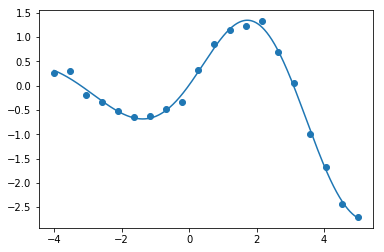

In [96]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain)
ax.plot(xtest, y_pred)

plt.show()

## Log Likelihood

In [4]:
from scipy.linalg import cholesky, solve,cho_solve, solve_triangular
import autograd.scipy.stats.multivariate_normal as mvn
from scipy.optimize import minimize, fmin_bfgs
import warnings
import autograd
import autograd.numpy as np
from autograd import value_and_grad, grad, elementwise_grad as egrad 

## Using Closed-Form

In [ ]:
class GaussianProcess(BaseEstimator, RegressorMixin):
    def __init__(self, jitter=1e-10, random_state=None, mean=0.0, 
                 signal_variance=1.0, length_scale=1.0,
                 noise_likelihood=0.01, n_restarts_optimizer=0):
        self.jitter = jitter
        self.random_state = random_state
        self.mean = mean
        self.signal_variance = signal_variance
        self.length_scale = length_scale
        self.noise_likelihood = noise_likelihood
        self.n_restarts_optimizer = n_restarts_optimizer
        
    def fit(self, X, y):
        
        self.X_train_ = X
        self.y_train_ = y
        
        # initial hyper-parameters
        theta0 = np.array([self.mean,
                           self.signal_variance,
                           self.noise_likelihood,
                           self.length_scale])
        bounds = ((1e-3, 1e3), (1e-10, 1e10), (1e-10, 1e10), (1e-10, 1e10))
        # define objective
        objective = lambda theta: -self.log_marginal_likelihood(theta)
        
        # minimize the objective function
        best_params = minimize(value_and_grad(objective), theta0, jac=True,
                               method='L-BFGS-B', bounds=bounds)
        
        # extract best params
        print(best_params)
        
        return self
    
    def predict(self, X, return_std=False):
        mean, signal_variance, noise_likelihood, length_scale = \
            self._get_kernel_params(self, self.theta)
        
        # Train test kernel
        K_train = self.rbf_covariance(X, signal_variance=signal_variance,
                                 length_scale=length_scale)
        K_trans = self.rbf_covariance(self.X_train_, X,
                                 signal_variance=signal_variance, 
                                 length_scale=length_scale)
        
        pred_mean = mean + np.dot(solve(K_train, K_trans).T, self.y_train_ )
        
        if not return_std:
            return pred_mean
        else:
            return None

    def log_marginal_likelihood(self, theta):
        
        mean, signal_variance, noise_likelihood, length_scale = \
            self._get_kernel_params(theta)
        print(theta)
        n_samples = self.X_train_.shape[0]
        
        # train kernel
        K = self.rbf_covariance(self.X_train_, length_scale=length_scale,
                           signal_variance=signal_variance)
        K += noise_likelihood * np.eye(n_samples)
#         mean = 0.0
        prior_mean = mean * np.ones(n_samples)
        
        return mvn.logpdf(self.y_train_.squeeze(), prior_mean, K)
    
    def _get_kernel_params(self, theta):
        
        mean = theta[0]
        signal_variance = theta[1]
        noise_likelihood = np.exp(theta[2]) + self.jitter
        length_scale = theta[3:]
        
        return mean, signal_variance, noise_likelihood, length_scale
    
    @staticmethod
    def rbf_covariance(X, y=None, signal_variance=1.0, length_scale=1.0):
        if y is None:
            y = X
        D = np.expand_dims(X / length_scale, 1) - np.expand_dims(y / length_scale, 0)
        
        return signal_variance * np.exp(-0.5 * np.sum(D**2, axis=2))

In [ ]:
gp_model = GaussianProcess()
gp_model.fit(xtrain, ytrain);

## Using PDFs

In [209]:
print(np.log(0.01))

-4.605170185988091


In [97]:
class GaussianProcess(BaseEstimator, RegressorMixin):
    def __init__(self, jitter=1e-8, random_state=None):
        self.jitter = jitter
        self.random_state = random_state
        
    def init_theta(self):
        """Initializes the hyperparameters."""
        signal_variance = 1.0
        length_scale = np.ones(self.X_train_.shape[1])
        noise_likelihood = 0.01
        theta = np.array([signal_variance, noise_likelihood, length_scale])
        return np.log(theta)
        
    def fit(self, X, y):
        
        self.X_train_ = X
        self.y_train_ = y
        
        # initial hyper-parameters
        theta0 = self.init_theta()
                
        
        # minimize the objective function
        best_params = minimize(value_and_grad(self.log_marginal_likelihood), theta0, jac=True,
                               method='L-BFGS-B')
        # Gather hyper parameters
        signal_variance, noise_likelihood, length_scale = \
            self._get_kernel_params(best_params.x)
        
        self.signal_variance = np.exp(signal_variance)
        self.noise_likelihood = np.exp(noise_likelihood)
        self.length_scale = np.exp(length_scale)

        # Calculate the weights
        K = self.rbf_covariance(X, length_scale=self.length_scale,
                                signal_variance=self.signal_variance) 
        K += self.noise_likelihood * np.eye(K.shape[0])
        L = np.linalg.cholesky(K + self.jitter * np.eye(K.shape[0]))
        weights = np.linalg.solve(L.T, np.linalg.solve(L, y))
        
        self.weights = weights
        self.L = L
        self.K = K
        return self
    
    def log_marginal_likelihood(self, theta):
        x_train = self.X_train_
        y_train = self.y_train_
        
        if np.ndim == 1:
            y_train = y_train[:, np.newaxis]
            
        # Gather hyper parameters
        signal_variance, noise_likelihood, length_scale = \
            self._get_kernel_params(theta)
        signal_variance = np.exp(signal_variance)
        noise_likelihood = np.exp(noise_likelihood)
        length_scale = np.exp(length_scale)
        
        n_samples = x_train.shape[0]
        
        # train kernel
        K = self.rbf_covariance(x_train, length_scale=length_scale,
                                signal_variance=signal_variance) 
        K += noise_likelihood * np.eye(n_samples)
        L = np.linalg.cholesky(K + self.jitter * np.eye(n_samples) )
        weights = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
        log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, weights)
        log_likelihood_dims -= np.log(np.diag(L)).sum()
        log_likelihood_dims -= (K.shape[0] / 2) * np.log(2 * np.pi)
        
        log_likelihood = log_likelihood_dims.sum(-1)
        
        return -log_likelihood    
    
    def predict(self, X, return_std=False):

        # Train test kernel
        K_trans = self.rbf_covariance(X, self.X_train_, 
                                      length_scale=self.length_scale, 
                                      signal_variance=self.signal_variance)        
        
        pred_mean = np.dot(K_trans, self.weights)
        
        if not return_std:
            return pred_mean
        else:
            return pred_mean, self.variance(X, K_trans=K_trans)

    def variance(self, X, K_trans=None):

        L_inv = solve_triangular(self.L.T, np.eye(self.L.shape[0]))
        K_inv = np.dot(L_inv, L_inv.T)
        if K_trans is None:
            K_trans = self.rbf_covariance(X, y=self.X_train_,
                                          length_scale=self.length_scale,
                                          signal_variance=self.signal_variance)

        # compute the variance
        y_var = np.diag(self.rbf_covariance(X, length_scale=self.length_scale,
                                            signal_variance=self.signal_variance)) \
                + self.noise_likelihood
        y_var -= np.einsum("ij,ij->i", np.dot(K_trans, K_inv), K_trans)

        return y_var

    
    def _get_kernel_params(self, theta):
        
        signal_variance = theta[0]
        noise_likelihood = theta[1] + self.jitter
        length_scale = theta[2:]
        
        return signal_variance, noise_likelihood, length_scale
    
    def rbf_covariance(self, X, y=None, signal_variance=1.0, length_scale=1.0):
        
        if y is None:
            y = X
            
        D = np.expand_dims(X / length_scale, 1) - np.expand_dims(y / length_scale, 0)
        
        return signal_variance * np.exp(-0.5 * np.sum(D**2, axis=2))
    def mu_grad(self, X, nder=1, return_std=False):

        # Construct the autogradient function for the
        # predictive mean
        mu = lambda x: self.predict(x)

        if nder == 1:
            grad_mu = egrad(mu)

            if not return_std:
                return grad_mu(X)
            else:
                return grad_mu(X), self.sigma_grad(X, nder=1)
        else:
            grad_mu = egrad(egrad(mu))
            if not return_std:
                return grad_mu(X)
            else:
                return grad_mu(X), self.sigma_grad(X, nder=2)

    def sigma_grad(self, X, nder=1):

        # Construct the autogradient function for the
        # predictive variance
        sigma = lambda x: self.variance(x)

        if nder == 1:
            grad_var = egrad(sigma)
            return grad_var(X)
        else:
            grad_var = egrad(egrad(sigma))
            return grad_var(X)

In [98]:
gp_model = GaussianProcess()
gp_model.fit(xtrain, ytrain);
y_pred = gp_model.predict(xtest)
y_pred, y_var = gp_model.predict(xtest, return_std=True)

In [99]:
%timeit gp_model.fit(xtrain, ytrain)

15.6 ms ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Derivatives

In [102]:
mu_der, var_der = gp_model.mu_grad(xtest, return_std=True)
mu_der2, var_der2 = gp_model.mu_grad(xtest, nder=2, return_std=True)


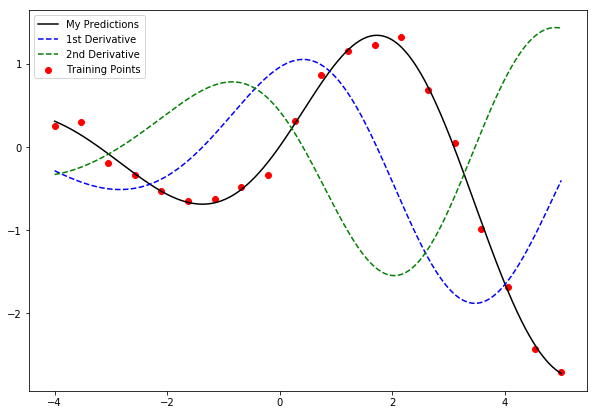

In [103]:
fig, ax = plt.subplots(figsize=(10, 7))

# ax.scatter(xtrain, ytrain)
ax.scatter(xtrain, ytrain, color='r', label='Training Points')
ax.plot(xtest, y_pred, color='k', label='My Predictions')
ax.plot(xtest, mu_der, color='b', linestyle="--", label='1st Derivative')
ax.plot(xtest, mu_der2, color='g', linestyle="--", label='2nd Derivative')

ax.legend()

plt.show()

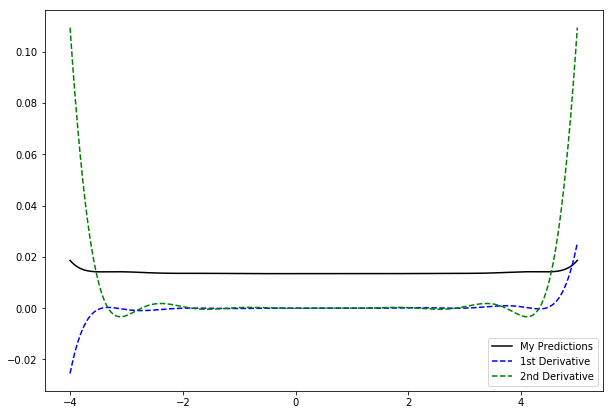

In [104]:
fig, ax = plt.subplots(figsize=(10, 7))

# ax.scatter(xtrain, ytrain)
# ax.scatter(xtrain, ytrain, color='r', label='Training Points')
ax.plot(xtest, y_var, color='k', label='My Predictions')
ax.plot(xtest, var_der, color='b', linestyle="--", label='1st Derivative')
ax.plot(xtest, var_der2, color='g', linestyle="--", label='2nd Derivative')

ax.legend()

plt.show()

# EXAMPLE


In [382]:
import autograd.numpy as np
from autograd import value_and_grad
from scipy.optimize import minimize
from scipy.stats import norm

# A minimal Gaussian process class
class GP:
    # Initialize the class
    def __init__(self, jitter=1e-8):        

        
        
               
        self.jitter = 1e-8
        

    def fit(self, X, y):
        self.D = X.shape[1]
        self.X = X
        self.y = y
        self.hyp = self.init_params()
        self.likelihood(self.hyp)
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        # Minimizes the negative log-marginal likelihood
        result = minimize(value_and_grad(self.likelihood), self.hyp, jac=True, 
                          method='L-BFGS-B', callback=self.callback)
        self.hyp = result.x
        
        return self
    # Initialize hyper-parameters        
    def init_params(self):
        hyp = np.log(np.ones(self.D+1))
        self.idx_theta = np.arange(hyp.shape[0])
        logsigma_n = np.array([-4.0])
        hyp = np.concatenate([hyp, logsigma_n])
        return hyp
    
    # A simple vectorized rbf kernel
    def kernel(self,x,xp,hyp):
        output_scale = np.exp(hyp[0])
        lengthscales = np.exp(hyp[1:])
        diffs = np.expand_dims(x /lengthscales, 1) - \
                np.expand_dims(xp/lengthscales, 0)
        return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))
        
    # Computes the negative log-marginal likelihood
    def likelihood(self, hyp):
        X = self.X
        y = self.y

        N = y.shape[0]
        
        logsigma_n = hyp[-1]
        sigma_n = np.exp(logsigma_n)
        
        theta = hyp[self.idx_theta]
        
        K = self.kernel(X, X, theta) + np.eye(N)*sigma_n
        L = np.linalg.cholesky(K + np.eye(N)*self.jitter) 
        self.L = L
        
        alpha = np.linalg.solve(np.transpose(L), np.linalg.solve(L,y))    
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*np.log(2.*np.pi)*N  
        return NLML[0,0]


        
    # Return posterior mean and variance at a set of test points
    def predict(self,X_star):
        X = self.X
        y = self.y
       
        L = self.L
                
        theta = self.hyp[self.idx_theta]
        
        psi = self.kernel(X_star, X, theta)

        alpha = np.linalg.solve(np.transpose(L), np.linalg.solve(L,y))
        pred_u_star = np.matmul(psi,alpha)
        print(alpha[0])

        beta = np.linalg.solve(np.transpose(L), np.linalg.solve(L,psi.T))
        var_u_star = self.kernel(X_star, X_star, theta) - np.matmul(psi,beta)
        
        return pred_u_star, var_u_star
    
    def ExpectedImprovement(self, X_star):
        X = self.X
        y = self.y
       
        L = self.L
                
        theta = self.hyp[self.idx_theta]
        
        psi = self.kernel(X_star, X, theta)

        alpha = np.linalg.solve(np.transpose(L), np.linalg.solve(L,y))
        pred_u_star = np.matmul(psi,alpha)

        beta = np.linalg.solve(np.transpose(L), np.linalg.solve(L,psi.T))
        var_u_star = self.kernel(X_star, X_star, theta) - np.matmul(psi,beta)
        var_u_star = np.abs(np.diag(var_u_star))[:,None]
        
        # Expected Improvement
        best = np.min(y)
        Z = (best - pred_u_star)/var_u_star
        EI_acq = (best - pred_u_star)*norm.cdf(Z) + var_u_star*norm.pdf(Z)

        return EI_acq
    
    def draw_prior_samples(self, X_star, N_samples = 1):
        N = X_star.shape[0]        
        theta = self.hyp[self.idx_theta]        
        K = self.kernel(X_star, X_star, theta)        
        return np.random.multivariate_normal(np.zeros(N), K, N_samples).T
                                             
    def draw_posterior_samples(self, X_star, N_samples = 1):
        X = self.X
        y = self.y
       
        L = self.L
                
        theta = self.hyp[self.idx_theta]
        
        psi = self.kernel(X_star, X, theta)

        alpha = np.linalg.solve(np.transpose(L), np.linalg.solve(L,y))
        pred_u_star = np.matmul(psi,alpha)

        beta = np.linalg.solve(np.transpose(L), np.linalg.solve(L,psi.T))
        var_u_star = self.kernel(X_star, X_star, theta) - np.matmul(psi,beta)
        
        return np.random.multivariate_normal(pred_u_star.flatten(), 
                                             var_u_star, N_samples).T
        
    #  Prints the negative log-marginal likelihood at each training step         
    def callback(self,params):
        print("Log likelihood {}".format(self.likelihood(params)))
        

In [383]:
gp_model = GP()
gp_model.fit(xtrain, ytrain);
ypred, var = gp_model.predict(xtest)


Total number of parameters: 3
Log likelihood 3.026004882322818
Log likelihood 2.412313785888095
Log likelihood 1.8326540764087227
Log likelihood 0.7837723350557333
Log likelihood 0.7187966448203547
Log likelihood 0.6997681626999395
Log likelihood 0.6876049693211925
Log likelihood 0.6874291307684643
Log likelihood 0.6874125619818763
Log likelihood 0.6874125474227206
Log likelihood 0.687412547145783
[0.36602546]


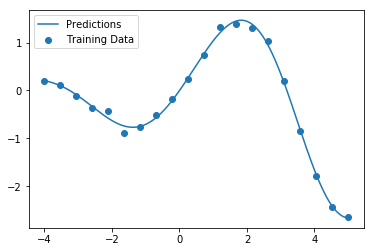

In [373]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, label='Training Data')
ax.plot(xtest, ypred, label='Predictions')

ax.legend()
plt.show()

# WITH RESTARTS

In [189]:
from scipy.optimize import minimize, fmin_l_bfgs_b


In [192]:
class GaussianProcess(BaseEstimator, RegressorMixin):
    def __init__(self, jitter=1e-9, random_state=None, mean=0.0,
                 signal_variance=1.0, length_scale=1.0,
                 noise_likelihood=0.1, n_restarts_optimizer=0):
        self.jitter = jitter
        self.random_state = random_state
        self.mean = mean
        self.signal_variance = signal_variance
        self.length_scale = length_scale
        self.noise_likelihood = noise_likelihood
        self.n_restarts_optimizer = n_restarts_optimizer

    def fit(self, X, y):

        self.X_train_ = X
        self.y_train_ = y

        # initial hyper-parameters
        theta0 = np.array([self.mean,
                           self.signal_variance,
                           self.noise_likelihood,
                           self.length_scale])
        bounds = ((1e-3, 1e3), (1e-10, 1e10), (1e-10, 1e10), (1e-10, 1e10))
        # define objective
        objective = lambda theta: -self.log_marginal_likelihood(theta)

        # minimize the objective function
        optimza = [self._constrained_optimization(self.obj_function, theta0, bounds)]
        # perform additional runs
        if self.n_restarts_optimizer:
            pass
        # extract best params
        print(best_params)

        return self

    def predict(self, X, return_std=False):
        mean, signal_variance, noise_likelihood, length_scale = \
            self._get_kernel_params(self, self.theta)

        # Train test kernel
        K_train = self.rbf_covariance(X, signal_variance=signal_variance,
                                      length_scale=length_scale)
        K_trans = self.rbf_covariance(self.X_train_, X,
                                      signal_variance=signal_variance,
                                      length_scale=length_scale)

        pred_mean = mean + np.dot(solve(K_train, K_trans).T, self.y_train_)

        if not return_std:
            return pred_mean
        else:
            return None

    def log_marginal_likelihood(self, theta):
        #         print(theta)
        #         print(self._get_kernel_params())
        # get kernel parameters
        mean, signal_variance, noise_likelihood, length_scale = \
            self._get_kernel_params(theta)

        n_samples = self.X_train_.shape[0]
        # train kernel
        K = self.rbf_covariance(self.X_train_, length_scale=length_scale,
                                signal_variance=signal_variance)
        K += noise_likelihood * np.eye(n_samples)

        prior_mean = mean * np.ones(n_samples)
        lml = mvn.logpdf(self.y_train_.squeeze(), prior_mean, K)
        return lml

    def obj_function(self, theta, eval_gradient=True):
        if eval_gradient:
            nll = lambda theta: self.log_marginal_likelihood(theta)
            auto_grad = autograd.value_and_grad(self.log_marginal_likelihood)
            lml, grad = auto_grad(theta)
            print(lml,grad)
            print('here')

            return -lml, -grad
        else:
            nll = lambda theta: self.log_marginal_likelihood(theta)
            auto_grad = autograd.grad(self.log_marginal_likelihood)
            return auto_grad(theta)

    def _constrained_optimization(self, obj_func, initial_theta, bounds):

        theta_opt, func_min, convergence_dict = \
            fmin_l_bfgs_b(obj_func, initial_theta, bounds)
        if convergence_dict["warnflag"] != 0:
            warnings.warn("fmin_bfgs_b terminated abnormaly with the "
                          "state:{s}".format(convergence_dict))

        return theta_opt, func_min

    def _get_kernel_params(self, theta):

        mean = theta[0]
        signal_variance = theta[1]
        noise_likelihood = np.exp(theta[2]) + self.jitter
        length_scale = theta[3:]
        return mean, signal_variance, noise_likelihood, length_scale

    @staticmethod
    def rbf_covariance(X, y=None, signal_variance=1.0, length_scale=1.0):
        if y is None:
            y = X
        D = np.expand_dims(X / length_scale, 1) - np.expand_dims(y / length_scale, 0)
        return signal_variance * np.exp(-0.5 * np.sum(D ** 2, axis=2))

In [193]:
gp_model = GaussianProcess()
gp_model.fit(xtrain, ytrain);

Autograd ArrayBox with value -27.124924441192245
-27.124924441192245 [-1.10529583  0.18297189  6.40788284 -1.5952848 ]
here


TypeError: 'tuple' object is not callable

In [204]:
import autograd.numpy.random as npr
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize
def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""

    def unpack_kernel_params(params):
        mean        = params[0]
        cov_params  = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale

    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean +   np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        return pred_mean, pred_cov

    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        return mvn.logpdf(y, prior_mean, cov_y_y)

    return num_cov_params + 2, predict, log_marginal_likelihood

# Define an example covariance function.
def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x /lengthscales, 1)\
          - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))


def build_toy_dataset(D=1, n_data=20, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 3, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = (np.cos(inputs) + rs.randn(n_data) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs  = inputs.reshape((len(inputs), D))
    return inputs, targets



In [205]:
D = 1

# Build model and objective function.
num_params, predict, log_marginal_likelihood = \
    make_gp_funs(rbf_covariance, num_cov_params=D + 1)

X, y = build_toy_dataset(D=D)
objective = lambda params: -log_marginal_likelihood(params, X, y)

# # Set up figure.
# fig = plt.figure(figsize=(12,8), facecolor='white')
# ax = fig.add_subplot(111, frameon=False)
# plt.show(block=False)

# def callback(params):
#     print("Log likelihood {}".format(-objective(params)))
#     plt.cla()

#     # Show posterior marginals.
#     plot_xs = np.reshape(np.linspace(-7, 7, 300), (300,1))
#     pred_mean, pred_cov = predict(params, X, y, plot_xs)
#     marg_std = np.sqrt(np.diag(pred_cov))
#     ax.plot(plot_xs, pred_mean, 'b')
#     ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
#             np.concatenate([pred_mean - 1.96 * marg_std,
#                            (pred_mean + 1.96 * marg_std)[::-1]]),
#             alpha=.15, fc='Blue', ec='None')

#     # Show samples from posterior.
#     rs = npr.RandomState(0)
#     sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
#     ax.plot(plot_xs, sampled_funcs.T)

#     ax.plot(X, y, 'kx')
#     ax.set_ylim([-1.5, 1.5])
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.draw()
#     plt.pause(1.0/60.0)

# Initialize covariance parameters
rs = npr.RandomState(0)
init_params = 0.1 * rs.randn(num_params)

print("Optimizing covariance parameters...")
print(init_params)
bounds = ((1e-10, 1e10), (1e-10, 1e10), (1e-10, 1e10), (1e-10, 1e10))
theta_opt, func_min, convergence_dict = fmin_l_bfgs_b(value_and_grad(objective), init_params, bounds=bounds)
if convergence_dict["warnflag"] != 0:
    warnings.warn("terminated abnormally... {}".format(convergence_dict))
    print(theta_opt)
# cov_params = minimize(value_and_grad(objective), init_params, jac=True,
#                       method='BFGS', callback=callback)
# print(cov_params)
# plt.pause(10.0)

Optimizing covariance parameters...
[0.17640523 0.04001572 0.0978738  0.22408932]
[0.17640523 0.04001572 0.0978738  0.22408932]


/home/emmanuel/anaconda3/envs/gp_autograd/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: terminated abnormally... {'grad': array([-0.05437591, -8.21081846, -1.13730548,  0.18202956]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}


## Autograd

In [16]:

from scipy.linalg import cholesky, cho_solve, solve_triangular

class GPAutoGrad(object):
    """GPAutoGrad implements a GP Regression algorithm which utilizes
    the autogradient to find the derivative of the mean function
    and the derivative of the predictive variance function.

    It inputs a trained model from the scikit-learn library using the
    kernel function: C() * RBF() + WhiteKernel()
    """

    def __init__(self, gp_model):
        self.gp_model = gp_model
        kernel_model = self.gp_model.kernel_
        self.signal_variance = kernel_model.get_params()['k1__k1__constant_value']
        self.length_scale = kernel_model.get_params()['k1__k2__length_scale']
        self.likelihood_variance = kernel_model.get_params()['k2__noise_level']
        self.weights = gp_model.alpha_
        self.x_train = gp_model.X_train_
        self.L = gp_model.L_
        print(self.L.shape)
    def fit(self):
        return self

    def predict(self, X, return_std=False):

        # kernel matrix
        K = self.rbf_covariance(X, y=self.x_train,
                                length_scale=self.length_scale,
                                scale=self.signal_variance)
        mean = np.dot(K, self.weights)
        if not return_std:
            return mean
        else:
            return mean, self.variance(X, K_trans=K)

    def variance(self, X, K_trans=None):

        L_inv = solve_triangular(self.L.T, np.eye(self.L.shape[0]))
        K_inv = np.dot(L_inv, L_inv.T)
        print(L_inv.shape, K_inv.shape)
        if K_trans is None:
            K_trans = self.rbf_covariance(X, y=self.x_train,
                                          length_scale=self.length_scale,
                                          scale=self.signal_variance)

        # compute the variance
        y_var = np.diag(self.rbf_covariance(X, length_scale=self.length_scale,
                                            scale=self.signal_variance)) \
                + self.likelihood_variance
        print(y_var.shape, K_trans.shape, K_inv.shape)
        y_var -= np.einsum("ij,ij->i", np.dot(K_trans, K_inv), K_trans)

        return y_var

    def mu_grad(self, X, nder=1, return_std=False):

        # Construct the autogradient function for the
        # predictive mean
        mu = lambda x: self.predict(x)

        if nder == 1:
            grad_mu = egrad(mu)

            if not return_std:
                return grad_mu(X)
            else:
                return grad_mu(X), self.sigma_grad(X, nder=1)
        else:
            grad_mu = egrad(egrad(mu))
            if not return_std:
                return grad_mu(X)
            else:
                return grad_mu(X), self.sigma_grad(X, nder=2)

    def sigma_grad(self, X, nder=1):

        # Construct the autogradient function for the
        # predictive variance
        sigma = lambda x: self.variance(x)

        if nder == 1:
            grad_var = egrad(sigma)
            return grad_var(X)
        else:
            grad_var = egrad(egrad(sigma))
            return grad_var(X)

    @staticmethod
    def rbf_covariance(X, y=None, scale=1.0, length_scale=1.0):
        if y is None:
            y = X
        D = np.expand_dims(X / length_scale, 1) \
            - np.expand_dims(y / length_scale, 0)
        return scale * np.exp(-0.5 * np.sum(D ** 2, axis=2))

    
    

In [18]:
def np_gradient(y_pred, xt, n_points=1000):
    return np.gradient(y_pred.squeeze(), xt.squeeze(), edge_order=2)[:, np.newaxis]

In [19]:
skgp_kernel = C() * RBF() + WhiteKernel()
skgp_model = GaussianProcessRegressor(kernel=skgp_kernel, random_state=seed, n_restarts_optimizer=0)

skgp_model.fit(xtrain, ytrain)

# initialize gp model
gp_autograd = GPAutoGrad(skgp_model)

gp_autograd.fit();

NameError: name 'C' is not defined

### First Derivative

In [111]:



mu_der, mu_var = gp_autograd.mu_grad(xtest, return_std=True)


# # My Gradient Function
# my_der = ard_derivative(xtrain, xtest, weights=gp_model.alpha_,
#                         length_scale=length_scale, scale=signal_variance)

# # Numpy gradient
# num_grad = np_gradient(y_pred, xtest)


(20, 20)
(20, 20) (20, 20)
(1000,) (1000, 20) (20, 20)


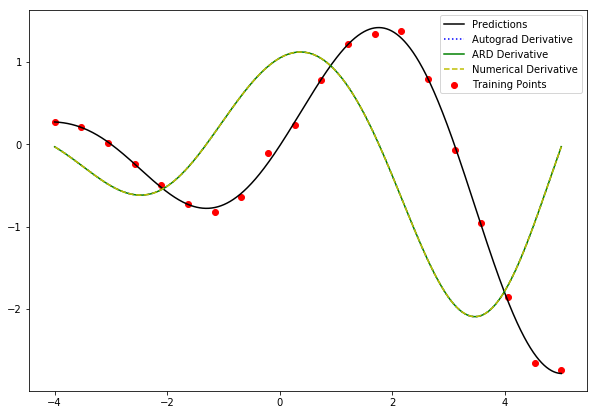

In [71]:
fig, ax = plt.subplots(figsize=(10, 7))

# ax.scatter(xtrain, ytrain)
ax.scatter(xtrain, ytrain, color='r', label='Training Points')
ax.plot(xtest, y_pred, color='k', label='Predictions')
ax.plot(xtest, mu_der, color='b', linestyle=":", label='Autograd Derivative')
ax.plot(xtest, my_der, color='g', linestyle="-", label='ARD Derivative')
ax.plot(xtest, num_grad, color='y', linestyle="--", label='Numerical Derivative')

ax.legend()

plt.show()

### 2nd Derivative

In [72]:
mu_der2 = gp_autograd.mu_grad(xtest, nder=2)

# Numpy gradient
num_grad = np_gradient(y_pred, xtest)
num_grad2 = np_gradient(num_grad, xtest)

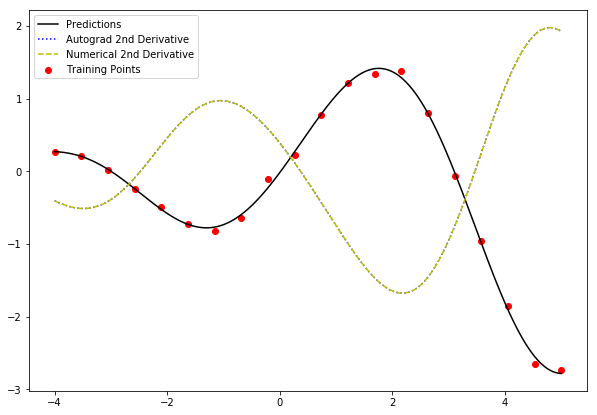

In [73]:
fig, ax = plt.subplots(figsize=(10, 7))

# ax.scatter(xtrain, ytrain)
ax.scatter(xtrain, ytrain, color='r', label='Training Points')
ax.plot(xtest, y_pred, color='k', label='Predictions')
ax.plot(xtest, mu_der2, color='b', linestyle=":", label='Autograd 2nd Derivative')
ax.plot(xtest, num_grad2, color='y', linestyle="--", label='Numerical 2nd Derivative')

ax.legend()

plt.show()

### Test Accuracy

In [75]:
assert(mu_der.shape == num_grad2.shape)
assert(mu_der2.all() == num_grad2.all())

### Test Speed

In [40]:
n_spoints = 10000
x_speed = np.linspace(-4, 5, n_spoints).reshape(n_spoints, 1)


In [41]:
print('\nSpeed of Autograd Function:')
%timeit gp_autograd.mu_grad(x_speed)

print('\nSpeed of ARD Derivative Function:')
%timeit ard_derivative(xtrain, xtest, weights=gp_model.alpha_, length_scale=length_scale, scale=signal_variance)

print('\nSpeed of Numerical Derivative:')
%timeit np_gradient(y_pred, xtest)


Speed of Autograd Function:
6.94 ms ± 432 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Speed of ARD Derivative Function:
4.09 ms ± 44.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Speed of Numerical Derivative:
56 µs ± 2.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Derivative of the Variance Function

In [42]:
sigma_der = gp_autograd.sigma_grad(xtest)
print(y_var.shape, xtest.shape)
nsigma_der = np.gradient(y_var.squeeze(), xtest.squeeze())

(1000,) (1000, 1)


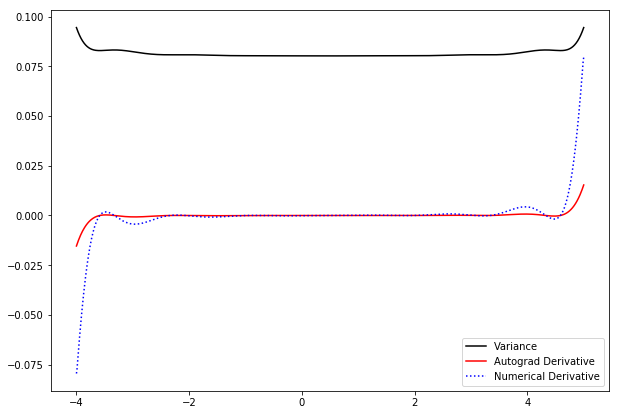

In [43]:
fig, ax = plt.subplots(figsize=(10, 7))

# ax.scatter(xtrain, ytrain)
# ax.scatter(xtrain, ytrain, color='r', label='Training Points')
ax.plot(xtest, y_var, color='k', label='Variance')
ax.plot(xtest, sigma_der, color='r', label='Autograd Derivative')
ax.plot(xtest, nsigma_der, color='b', linestyle=":", label='Numerical Derivative')
# ax.plot(xtest, my_der, color='g', linestyle="-", label='ARD Derivative')
# ax.plot(xtest, num_grad, color='y', linestyle="-", label='Numerical Derivative')

ax.legend()

plt.show()

In [44]:
print('\nSpeed of ARD Derivative Function:')
%timeit gp_autograd.sigma_grad(xtest)

print('\nSpeed of Numerical Derivative:')
%timeit np.gradient(y_var.squeeze(), xtest.squeeze())


Speed of ARD Derivative Function:
37.9 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Speed of Numerical Derivative:
52.1 µs ± 2.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
import autograd.scipy.stats.multivariate_normal as mvn

class GaussianProcessRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, kernel='rbf', jitter=1e-09, random_state=None):
        self.kernel = kernel
        self.jitter = jitter
        self.random_state = random_state

    def fit(self, X, y):
        
        # standardize the data
        self.X = X
        self.Y = y
        
        # initialize parameters
        noise_scale = 0.01
        length_scale = 10.0
        theta0 = np.array([noise_scale, length_scale])
        bounds = ((1e-10, 1e10), (1e-10, 1e10))
        
        # define objective function: negative log marginal likelihood
        objective = lambda theta0: -self.log_marginal_likelihood(theta0)
        
        # minimize negative log marginal likelihood
        cov_params = minimize(value_and_grad(objective), theta0, jac=True, args=(), method='L-BFGS-B', bounds=bounds)
        
        # get params
        self.noise_scale, self.length_scale = self._unpack_kernel_params(cov_params.x)
        
        # calculate the weights
        K = self.K(self.X, length_scale=self.length_scale)
        self.L = np.linalg.cholesky(K + noise_scale * np.eye(K.shape[0]))
        weights =  np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.Y))
        self.weights_ = weights
        
        return self
    
#     def K(self, X, Y=None, length_scale=1.0, scale=1.0):
        
#         scale_term = - 0.5 / np.power(length_scale, 2)
        
#         dists

#         if Y is None:

#             dists = pdist(X, metric='sqeuclidean')

#             K = np.exp(scale_term * dists)

#             K = squareform(K)

#             np.fill_diagonal(K, 1)

#         else:

#             dists = cdist(X, Y, metric='sqeuclidean')

#             K = np.exp(scale_term  * dists) 


#         return K
    def K(self, X, Y=None, length_scale=1.0, scale=1.0):
        
#         scale_term = - 0.5 / np.power(length_scale, 2)
        
        diffs = np.expand_dims(X / length_scales, 1) \
            - np.expanddims(Y / length_scales, 0)


        return np.exp(-0.5 * np.sum(diffs**2, axis=2))
    
    def predict(self, X, return_std=None):
        
        K = self.K(X, self.X, length_scale=self.length_scale)
        
        predictions = np.dot(K, self.weights_)
        if not return_std:
            return predictions
        else:            
            K_test = rbf_covariance(X, length_scale=self.length_scale)
            v = np.linalg.solve(self.L, K.T)
            std_dev = np.sqrt(self.noise_scale + np.diag(K_test - np.dot(v.T, v)))
            return predictions, std_dev
    
    def pred_grad(self, X):
        
        mu = lambda x: self.predict(x, return_std=False)
        auto_grad = autograd.grad(mu)
        
        return auto_grad(X)
    
    def _unpack_kernel_params(self, params):
        return params[0], params[1:]
    
    def log_marginal_likelihood(self, params):
        
        x_train = self.X
        y_train = self.Y
        
        # unpack the parameters
        noise_scale, length_scale = self._unpack_kernel_params(params)
        
        # calculate the covariance matrix
        K = self.K(x_train, length_scale=length_scale)
        K_chol = K + noise_scale * np.eye(K.shape[0])
#         K += self.jitter * np.eye(K.shape[0])
        
        # Solve the cholesky
        print(K.shape)
        try:
            self.L = np.linalg.cholesky(K_chol)
            
        except np.linalg.LinAlgError:
            return -np.inf
                
        if y_train.ndim == 1:
            y_train = y_train[:, np.newaxis]
        
        # get the weights
        alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, y_train))
        
        # compute log-likelihood
        log_likelihood_dims = -0.5 * np.einsum('ik,ik->k', y_train, alpha)
        log_likelihood_dims -= np.log(np.diag(self.L)).sum()
        log_likelihood_dims -= (K.shape[0] / 2 ) * np.log(2 * np.pi)
        
        log_likelihood = log_likelihood_dims.sum(-1)
        
        return log_likelihood
        

In [4]:
import autograd.scipy.stats.multivariate_normal as mvn

class GaussianProcessRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, kernel='rbf', jitter=1e-09, random_state=None):
        self.kernel = kernel
        self.jitter = jitter
        self.random_state = random_state

    def fit(self, X, y):
        
        # standardize the data
        self.X = X
        self.Y = y
        
        # initialize parameters
        noise_scale = 0.01
        length_scale = 10.0
        theta0 = np.array([noise_scale, length_scale])
        bounds = ((1e-10, 1e10), (1e-10, 1e10))
        
        # define objective function: negative log marginal likelihood
        objective = lambda theta0: -self.log_marginal_likelihood(theta0)
        
        # minimize negative log marginal likelihood
        cov_params = minimize(value_and_grad(objective), theta0, jac=True, args=(), method='L-BFGS-B', bounds=bounds)
        
        # get params
        self.noise_scale, self.length_scale = self._unpack_kernel_params(cov_params.x)
        
        # calculate the weights
        K = self.K(self.X, length_scale=self.length_scale)
        self.L = np.linalg.cholesky(K + noise_scale * np.eye(K.shape[0]))
        weights =  np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.Y))
        self.weights_ = weights
        
        return self
    
    def K(self, X, Y=None, length_scale=1.0, scale=1.0):
        
        scale_term = - 0.5 / np.power(length_scale, 2)

        if Y is None:

            dists = pdist(X, metric='sqeuclidean')

            K = np.exp(scale_term * dists)

            K = squareform(K)

            np.fill_diagonal(K, 1)

        else:

            dists = cdist(X, Y, metric='sqeuclidean')

            K = np.exp(scale_term  * dists) 


        return K
    
    def predict(self, X, return_std=None):
        
        K = self.K(X, self.X, length_scale=self.length_scale)
        
        predictions = np.dot(K, self.weights_)
        if not return_std:
            return predictions
        else:            
            K_test = rbf_covariance(X, length_scale=self.length_scale)
            v = np.linalg.solve(self.L, K.T)
            std_dev = np.sqrt(self.noise_scale + np.diag(K_test - np.dot(v.T, v)))
            return predictions, std_dev
    
    def pred_grad(self, X):
        
        mu = lambda x: self.predict(x, return_std=False)
        auto_grad = autograd.grad(mu)
        
        return auto_grad(X)
    
    def _unpack_kernel_params(self, params):
        return params[0], params[1:]
    
    def log_marginal_likelihood(self, params):
        
        x_train = self.X
        y_train = self.Y
        
        # unpack the parameters
        noise_scale, length_scale = self._unpack_kernel_params(params)
        ktrain = self.K(x_train, length_scale=length_scale) 
        white_kern = noise_scale * np.eye(len(y_train))
        print(ktrain.shape, white_kern.shape)
        K = ktrain + white_kern
#         # calculate the covariance matrix
#         K = self.K(x_train, length_scale=length_scale)
#         K_chol = K + noise_scale * np.eye(K.shape[0])
# #         K += self.jitter * np.eye(K.shape[0])
        
#         # Solve the cholesky
#         print(K.shape)
#         try:
#             self.L = np.linalg.cholesky(K_chol)
            
#         except np.linalg.LinAlgError:
#             return -np.inf
                
#         if y_train.ndim == 1:
#             y_train = y_train[:, np.newaxis]
        
#         # get the weights
#         alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, y_train))
        
#         # compute log-likelihood
#         log_likelihood_dims = -0.5 * np.einsum('ik,ik->k', y_train, alpha)
#         log_likelihood_dims -= np.log(np.diag(self.L)).sum()
#         log_likelihood_dims -= (K.shape[0] / 2 ) * np.log(2 * np.pi)
        
#         log_likelihood = log_likelihood_dims.sum(-1)
        tmp = mvn.logpdf(y_train, 0.0, Kernel)
        print(tmp)
        return tmp
        

### Data

X training data: (30, 1)
X testing data: (30, 1)


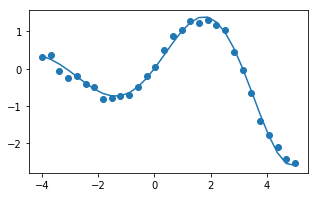

In [5]:
# get some toy data
d_dimensions = 1
n_samples = 20
noise_std = 0.1
seed = 123
rs = np.random.RandomState(seed)

n_train = 30
n_test = 30
xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)
print('X training data:', xtrain.shape)
print('X testing data:', xtest.shape)


# Labels
f = lambda x: np.sin(x) * np.exp(0.2 * x)
ytrain = f(xtrain) + noise_std * np.random.randn(n_train, 1)
ytest = f(xtest)
# Plot the function
fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(xtrain, ytrain)
ax.plot(xtest, ytest)

plt.show()



### Test Function

In [6]:
# Initialize the model
gp_model = GaussianProcessRegressor(random_state=seed)

# fit the gp model to the inputs and targets
gp_model.fit(xtrain, ytrain)

y_pred, sigma = gp_model.predict(xtest, return_std=True)
# print(mu_der)
# tmp = y_pred.astype()
# print(tmp)
fig, ax = plt.subplots()

# ax.scatter(xtrain, ytrain)
ax.scatter(xtrain, ytrain)
ax.plot(xtest, y_pred)
ax.plot(xtest, mu_der)
plt.show()

(30, 30) (30, 30)


AttributeError: _trace

In [1]:
# Initialize the model
gp_model = GaussianProcessRegressor(random_state=seed)

# fit the gp model to the inputs and targets
gp_model.fit(xtrain, ytrain)


mu = lambda x: gp_model.predict(x)
y_pred = mu(xtest)
print(y_pred.shape)
auto_grad = autograd.grad(mu)

tmp = auto_grad(xtest)

NameError: name 'GaussianProcessRegressor' is not defined

In [112]:
import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import grad

def taylor_sine(x):  # Taylor approximation to sine function
    ans = currterm = x
    i = 0
    while np.abs(currterm) > 0.001:
        currterm = -currterm * x**2 / ((2 * i + 3) * (2 * i + 2))
        ans = ans + currterm
        i += 1
    return ans

grad_sine = grad(taylor_sine)
print("Gradient of sin(pi) is", grad_sine(np.pi))
print()

Initial loss: 2.772588722239781
Trained loss: 1.067270675787016


In [114]:
print(training_gradient_fun)

<function unary_to_nary.<locals>.nary_operator.<locals>.nary_f at 0x7f6f8ecac0d0>


In [9]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize


def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""

    def unpack_kernel_params(params):
        mean        = params[0]
        cov_params  = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale

    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean +   np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        return pred_mean, pred_cov

    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        log_max = mvn.logpdf(y, prior_mean, cov_y_y)
        print(log_max)
        return log_max

    return num_cov_params + 2, predict, log_marginal_likelihood

# Define an example covariance function.
def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x /lengthscales, 1)\
          - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))


def build_toy_dataset(D=1, n_data=20, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 3, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = (np.cos(inputs) + rs.randn(n_data) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs  = inputs.reshape((len(inputs), D))
    return inputs, targets


def callback(params):
    print("Log likelihood {}".format(-objective(params)))
    plt.cla()

    # Show posterior marginals.
    plot_xs = np.reshape(np.linspace(-7, 7, 300), (300,1))
    pred_mean, pred_cov = predict(params, X, y, plot_xs)
    marg_std = np.sqrt(np.diag(pred_cov))
    ax.plot(plot_xs, pred_mean, 'b')
    ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
            np.concatenate([pred_mean - 1.96 * marg_std,
                           (pred_mean + 1.96 * marg_std)[::-1]]),
            alpha=.15, fc='Blue', ec='None')

    # Show samples from posterior.
    rs = npr.RandomState(0)
    sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
    ax.plot(plot_xs, sampled_funcs.T)


    ax.plot(X, y, 'kx')
    ax.set_ylim([-1.5, 1.5])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.draw()
    plt.pause(1.0/60.0)

In [10]:


D = 1

# Build model and objective function.
num_params, predict, log_marginal_likelihood = \
    make_gp_funs(rbf_covariance, num_cov_params=D + 1)

X, y = build_toy_dataset(D=D)
objective = lambda params: -log_marginal_likelihood(params, X, y)



# Initialize covariance parameters
rs = npr.RandomState(0)
init_params = 0.1 * rs.randn(num_params)

print("Optimizing covariance parameters...")
cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                      method='CG')


Optimizing covariance parameters...
Autograd ArrayBox with value -22.415047313431167
Autograd ArrayBox with value -22.415047313431167
Autograd ArrayBox with value -31.027858408194493
Autograd ArrayBox with value -23.16615895604356
Autograd ArrayBox with value -22.483631947480745
Autograd ArrayBox with value -22.421337554524072
Autograd ArrayBox with value -22.415624457696325
Autograd ArrayBox with value -22.415100269737973
Autograd ArrayBox with value -22.415052172493635
Autograd ArrayBox with value -22.415047759279766
Autograd ArrayBox with value -22.415047354340498
Autograd ArrayBox with value -22.41504731718485
Autograd ArrayBox with value -22.415047313775595
Autograd ArrayBox with value -22.41504731346277
Autograd ArrayBox with value -22.415047313434062
Autograd ArrayBox with value -22.415047313431437
Autograd ArrayBox with value -22.415047313431195
Autograd ArrayBox with value -22.415047313431167
Autograd ArrayBox with value -22.41504731343117
Autograd ArrayBox with value -22.4150

In [105]:
print(predict(X, y, xstar))

NameError: name 'xstar' is not defined

In [152]:
# Build model and objective function.
num_params, predict, log_marginal_likelihood = \
    make_gp_funs(rbf_covariance, num_cov_params=D + 1)

X, y = build_toy_dataset(D=D)
objective = lambda params: -log_marginal_likelihood(params, X, y)

print(objective(init_params))

-22.415047313431167
22.415047313431167
